# Final project on video game play times

In [1]:
import numpy as np
import pandas as pd

## Importing/manipulating first data source

Importing Kaggle dataset for behaviors of different Steam users

In [2]:
df = pd.read_csv("data/steam-200k.csv", names = ["user ID", "game", "behavior", "behavior_num", "null"])

In [3]:
df.head()

,user ID,game,behavior,behavior_num,null
0,151603712,The Elder Scrolls V Skyrim,purchase,1.0,0
1,151603712,The Elder Scrolls V Skyrim,play,273.0,0
2,151603712,Fallout 4,purchase,1.0,0
3,151603712,Fallout 4,play,87.0,0
4,151603712,Spore,purchase,1.0,0


Manipulating dataset to suit my purposes

In [4]:
df2 = df[df.behavior=="play"].drop(columns=["user ID", "behavior", "null"]).rename(index=str, columns={"behavior_num": "hours played"})
df2.head()

,game,hours played
1,The Elder Scrolls V Skyrim,273.0
3,Fallout 4,87.0
5,Spore,14.9
7,Fallout New Vegas,12.1
9,Left 4 Dead 2,8.9


In [5]:
df2.count()

game            70489
hours played    70489
dtype: int64

In [6]:
hours = df2.groupby("game").mean()
hours.head()

,hours played
game,
007 Legends,0.70
0RBITALIS,0.40
1... 2... 3... KICK IT! (Drop That Beat Like an Ugly Baby),4.00
10 Second Ninja,2.95
"10,000,000",3.60


In [7]:
hours.count()

hours played    3600
dtype: int64

## Importing/manipulating second data source

Getting data from IGDB API to fetch relevant data for each game

In [8]:
import requests
import json

def getIgdbData(name):
    headers = {
        # API key hidden for security purposes, can get one for free at https://api.igdb.com/
        "user-key": user_key,
        "user-agent": "Lawrence Zheng's personal project",
    }
    payload = "fields name,first_release_date, genres, rating; where name = \"" + name + "\";"
    url = "https://api-v3.igdb.com/games"
    response = requests.post(url, headers=headers, data=payload)
    results = json.loads(response.content)
    return results

In [9]:
getIgdbData("APOX")

[{'id': 9981,
  'first_release_date': 1295481600,
  'genres': [8, 9, 11, 15, 32],
  'name': 'APOX',
  'platforms': [92],
  'rating': 40.0}]

Iterating through each game listed on previous dataset and combining

In [10]:
results = []
read_cache = True
try:
    if read_cache is False:
        for row_index,row in hours.iterrows():
            result = getIgdbData(row_index)
            if len(result) != 0:
                result_dict = result[0]
                result_dict['time_played'] = row['hours played']
                results.append(result[0])
        dumped_cache = json.dumps(results)
        cache = open("IGDB_cache.json", 'w', encoding="utf-8")
        cache.write(dumped_cache)
        cache.close()
    else:
        print("Opting to read from cache file at IGDB_cache.json instead of connecting to API")
        cache_file = open("IGDB_cache.json",'r', encoding = "utf-8")
        cache_contents = cache_file.read()
        cache_file.close()
        results = json.loads(cache_contents)
except:
    print("Could not connect to IGDB API, now reading from cache file at IGDB_cache.json")
    cache_file = open("IGDB_cache.json",'r', encoding = "utf-8")
    cache_contents = cache_file.read()
    cache_file.close()
    results = json.loads(cache_contents)

In [15]:
df3 = pd.DataFrame(results)
df3 = df3[['name', 'first_release_date', 'genres', 'rating', 'time_played']].dropna(subset=["first_release_date"])

In [16]:
df3.head()

,name,first_release_date,genres,rating,time_played
0,007 Legends,1.350346e+09,[5],51.367626,0.70
1,1... 2... 3... KICK IT! (Drop That Beat Like a...,1.301616e+09,"[7, 32]",40.000000,4.00
2,10 Second Ninja,1.393978e+09,"[8, 32]",80.000000,2.95
3,100% Orange Juice,1.250294e+09,"[15, 16, 32]",80.000000,8.70
4,1000 Amps,1.329869e+09,"[8, 31, 32]",80.000000,0.10


Converting from Unix timestamps to year

In [17]:
from datetime import datetime

def convert_unix_year(x):
    return datetime.fromtimestamp(x).year

df3['first_release_date'] = df3['first_release_date'].apply(convert_unix_year)

In [18]:
df3.head()

,name,first_release_date,genres,rating,time_played
0,007 Legends,2012,[5],51.367626,0.70
1,1... 2... 3... KICK IT! (Drop That Beat Like a...,2011,"[7, 32]",40.000000,4.00
2,10 Second Ninja,2014,"[8, 32]",80.000000,2.95
3,100% Orange Juice,2009,"[15, 16, 32]",80.000000,8.70
4,1000 Amps,2012,"[8, 31, 32]",80.000000,0.10


# Visualizations

## Visualization 1: How does average time spent on a game vary based on the release year of the game?

In [19]:
df4 = df3[['first_release_date', 'time_played']].groupby("first_release_date").mean()

In [20]:
df4.head()

,time_played
first_release_date,
1980,0.200000
1981,9.377941
1983,0.850000
1985,1.950000
1986,3.624780


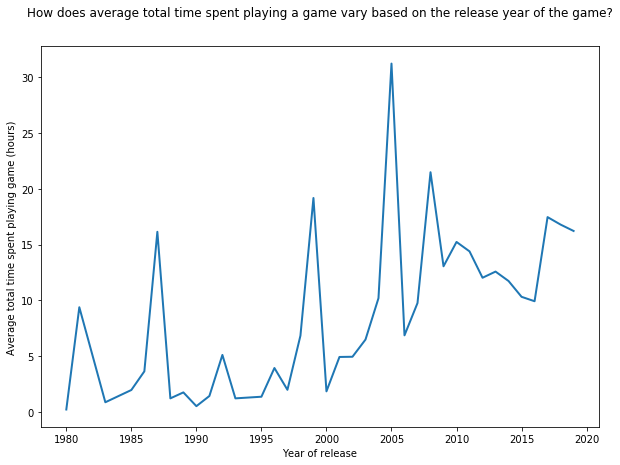

In [137]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,7))

plt.plot(df4.index, df4["time_played"], linewidth=2)
plt.title('How does average total time spent playing a game vary based on the release year of the game?', pad=30)
plt.xlabel('Year of release')
plt.ylabel('Average total time spent playing game (hours)')
plt.show()

Investigating strange spike around 2005

In [142]:
anomaly = df3[df3['first_release_date'] == 2005].sort_values(by='time_played', ascending=False).head(7)
anomaly

,name,first_release_date,genres,rating,time_played
143,Avernum 4,2005,"[12, 32]",70.000000,228.000
1990,Uncharted Waters Online,2005,"[12, 15, 31]",NaN,181.000
938,Imperial Glory,2005,"[11, 15, 24]",89.728647,170.000
845,Guild Wars,2005,"[12, 15, 31]",78.984744,147.925
1563,Shattered Union,2005,"[15, 16, 24]",50.000000,116.000
1009,Knights of Honor,2005,"[11, 13, 15]",85.995377,39.800
1611,Sniper Elite,2005,"[5, 13, 15, 24]",69.982921,26.710


## Visualization 2: How does average time spent on a game vary with the IGDB rating of the game?

In [57]:
df5 = df3[['rating', 'time_played', 'first_release_date']]

In [58]:
df5.head()

,rating,time_played,first_release_date
0,51.367626,0.70,2012
1,40.000000,4.00,2011
2,80.000000,2.95,2014
3,80.000000,8.70,2009
4,80.000000,0.10,2012


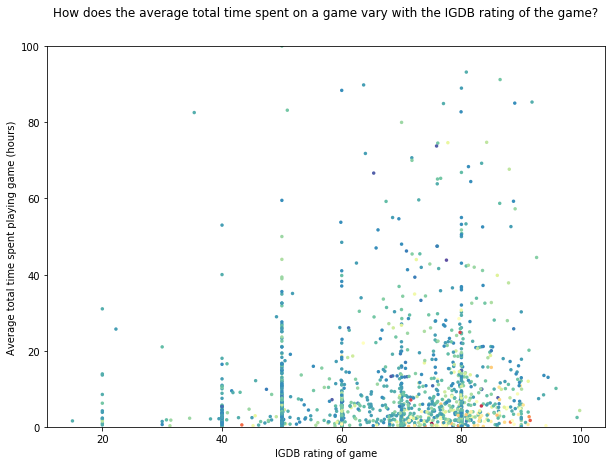

In [136]:
from matplotlib import cm



cmap = cm.get_cmap('Spectral')
fig, ax = plt.subplots(1, figsize=(10,7))

ax.scatter(df5['rating'], df5['time_played'], c=df5['first_release_date'], s=12, cmap=cmap, edgecolor='None')
ax.set_ybound(lower=0, upper=100)
ax.set_ylabel('Average total time spent playing game (hours)')
ax.set_xlabel('IGDB rating of game')
ax.set_title('How does the average total time spent on a game vary with the IGDB rating of the game?', pad=30)
plt.show()

## Visualization 3: Which genres of video games have the highest average time spent?

In [30]:
genre_times = []
for row_index,row in df3[['genres', 'time_played']].iterrows():
    if isinstance(row['genres'], (list,)):
        for genre in row['genres']:
            genre_time = {'genre': genre, 'time_played': row['time_played']}
            genre_times.append(genre_time)

df6 = pd.DataFrame(genre_times)

In [31]:
df6.head()

,genre,time_played
0,5,0.70
1,7,4.00
2,32,4.00
3,8,2.95
4,32,2.95


In [32]:
df6 = df6.groupby("genre").mean()

In [33]:
df6.sort_values(by='time_played', ascending=False).head(10)

,time_played
genre,
14,40.364583
24,23.666473
13,21.543470
15,17.990506
12,15.950986
11,15.082164
16,13.340775
25,11.353891
26,10.669444


In [43]:
def getIgdbGenre(id):
    headers = {
        # API key hidden for security purposes, can get one for free at https://api.igdb.com/
        "user-key": user_key,
        "user-agent": "Lawrence Zheng's personal project",
    }
    payload = "fields name; where id = " + str(id) + ";"
    url = "https://api-v3.igdb.com/genres"
    response = requests.post(url, headers=headers, data=payload)
    results = json.loads(response.content)
    return results[0]['name']


In [44]:
genre_times_converted = []
for row_index,row in df6.iterrows():
    genre_time = {'genre': getIgdbGenre(row_index), 'time_played': row['time_played']}
    genre_times_converted.append(genre_time)
df7 = pd.DataFrame(genre_times_converted)

In [131]:
df7 = df7.sort_values(by='time_played', ascending=False).head(10).sort_values(by='time_played', ascending=True)

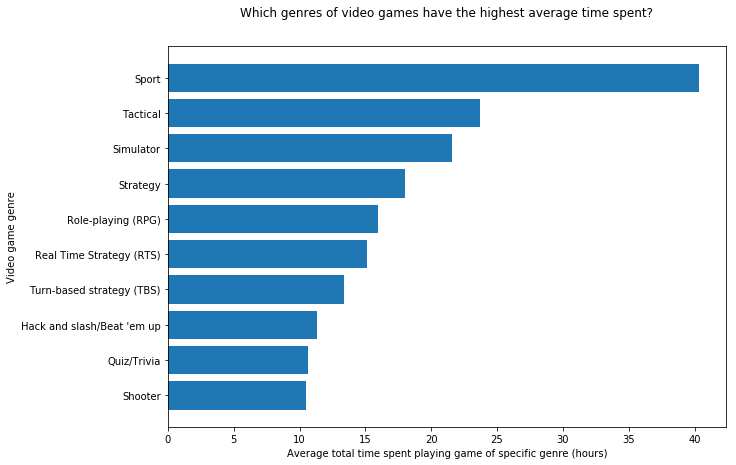

In [139]:
plt.figure(figsize=(10,7))

plt.barh(df7["genre"], df7["time_played"])
plt.title('Which genres of video games have the highest average time spent?', pad=30)
plt.xlabel('Average total time spent playing game of specific genre (hours)')
plt.ylabel('Video game genre')
plt.show()